# Bayesian Network

In [3]:
from IPython.display import Image

## Bayesian Models
1. What are Bayesian Models
2. Independencies in Bayesian Networks
3. How is Bayesian Model encoding the Joint Distribution
4. How we do inference from Bayesian models
5. Types of methods for inference

### 1. What are Bayesian Models
A Bayesian network, Bayes network, belief network, Bayes(ian) model or probabilistic directed acyclic graphical model is a probabilistic graphical model (a type of statistical model) that represents a set of random variables and their conditional dependencies via a directed acyclic graph (DAG). Bayesian networks are mostly used when we want to represent causal relationship between the random variables. Bayesian Networks are parameterized using Conditional Probability Distributions (CPD). Each node in the network is parameterized using $P(node | Pa(node))$ where $Pa(node)$ represents the parents of node in the network.

We can take the example of the student model:

In [4]:
Image('../images/2/student_full_param.png')

FileNotFoundError: No such file or directory: '../images/2/student_full_param.png'

FileNotFoundError: No such file or directory: '../images/2/student_full_param.png'

<IPython.core.display.Image object>

In pgmpy we define the network structure and the CPDs separately and then associate them with the structure. Here's an example for defining the above model:

In [5]:
from pgmpy.models import BayesianModel
from pgmpy.factors.discrete import TabularCPD

# Defining the model structure. We can define the network by just passing a list of edges.
model = BayesianModel([('D', 'G'), ('I', 'G'), ('G', 'L'), ('I', 'S')])

# Defining individual CPDs.
cpd_d = TabularCPD(variable='D', variable_card=2, values=[[0.6], [0.4]])
cpd_i = TabularCPD(variable='I', variable_card=2, values=[[0.7], [0.3]])

# The representation of CPD in pgmpy is a bit different than the CPD shown in the above picture. In pgmpy the colums
# are the evidences and rows are the states of the variable. So the grade CPD is represented like this:
#
#    +---------+---------+---------+---------+---------+
#    | diff    | intel_0 | intel_0 | intel_1 | intel_1 |
#    +---------+---------+---------+---------+---------+
#    | intel   | diff_0  | diff_1  | diff_0  | diff_1  |
#    +---------+---------+---------+---------+---------+
#    | grade_0 | 0.3     | 0.05    | 0.9     | 0.5     |
#    +---------+---------+---------+---------+---------+
#    | grade_1 | 0.4     | 0.25    | 0.08    | 0.3     |
#    +---------+---------+---------+---------+---------+
#    | grade_2 | 0.3     | 0.7     | 0.02    | 0.2     |
#    +---------+---------+---------+---------+---------+

cpd_g = TabularCPD(variable='G', variable_card=3, 
                   values=[[0.3, 0.05, 0.9,  0.5],
                           [0.4, 0.25, 0.08, 0.3],
                           [0.3, 0.7,  0.02, 0.2]],
                  evidence=['I', 'D'],
                  evidence_card=[2, 2])

cpd_l = TabularCPD(variable='L', variable_card=2, 
                   values=[[0.1, 0.4, 0.99],
                           [0.9, 0.6, 0.01]],
                   evidence=['G'],
                   evidence_card=[3])

cpd_s = TabularCPD(variable='S', variable_card=2,
                   values=[[0.95, 0.2],
                           [0.05, 0.8]],
                   evidence=['I'],
                   evidence_card=[2])

# Associating the CPDs with the network
model.add_cpds(cpd_d, cpd_i, cpd_g, cpd_l, cpd_s)

# check_model checks for the network structure and CPDs and verifies that the CPDs are correctly 
# defined and sum to 1.
model.check_model()

True

In [6]:
# CPDs can also be defined using the state names of the variables. If the state names are not provided
# like in the previous example, pgmpy will automatically assign names as: 0, 1, 2, ....

cpd_d_sn = TabularCPD(variable='D', variable_card=2, values=[[0.6], [0.4]], state_names={'D': ['Easy', 'Hard']})
cpd_i_sn = TabularCPD(variable='I', variable_card=2, values=[[0.7], [0.3]], state_names={'I': ['Dumb', 'Intelligent']})
cpd_g_sn = TabularCPD(variable='G', variable_card=3, 
                      values=[[0.3, 0.05, 0.9,  0.5],
                              [0.4, 0.25, 0.08, 0.3],
                              [0.3, 0.7,  0.02, 0.2]],
                      evidence=['I', 'D'],
                      evidence_card=[2, 2],
                      state_names={'G': ['A', 'B', 'C'],
                                   'I': ['Dumb', 'Intelligent'],
                                   'D': ['Easy', 'Hard']})

cpd_l_sn = TabularCPD(variable='L', variable_card=2, 
                      values=[[0.1, 0.4, 0.99],
                              [0.9, 0.6, 0.01]],
                      evidence=['G'],
                      evidence_card=[3],
                      state_names={'L': ['Bad', 'Good'],
                                   'G': ['A', 'B', 'C']})

cpd_s_sn = TabularCPD(variable='S', variable_card=2,
                      values=[[0.95, 0.2],
                              [0.05, 0.8]],
                      evidence=['I'],
                      evidence_card=[2],
                      state_names={'S': ['Bad', 'Good'],
                                   'I': ['Dumb', 'Intelligent']})

# These defined CPDs can be added to the model. Since, the model already has CPDs associated to variables, it will
# show warning that pmgpy is now replacing those CPDs with the new ones.
model.add_cpds(cpd_d_sn, cpd_i_sn, cpd_g_sn, cpd_l_sn, cpd_s_sn)
model.check_model()

True

In [7]:
# We can now call some methods on the BayesianModel object.
model.get_cpds()

[<TabularCPD representing P(D:2) at 0x164b6fda0>,
 <TabularCPD representing P(I:2) at 0x169ea3b90>,
 <TabularCPD representing P(G:3 | I:2, D:2) at 0x169ea3e90>,
 <TabularCPD representing P(L:2 | G:3) at 0x169ea3350>,
 <TabularCPD representing P(S:2 | I:2) at 0x169ea38c0>]

In [8]:
# Printing a CPD which doesn't have state names defined.
print(cpd_g)

+------+------+------+------+------+
| I    | I(0) | I(0) | I(1) | I(1) |
+------+------+------+------+------+
| D    | D(0) | D(1) | D(0) | D(1) |
+------+------+------+------+------+
| G(0) | 0.3  | 0.05 | 0.9  | 0.5  |
+------+------+------+------+------+
| G(1) | 0.4  | 0.25 | 0.08 | 0.3  |
+------+------+------+------+------+
| G(2) | 0.3  | 0.7  | 0.02 | 0.2  |
+------+------+------+------+------+


In [40]:
# Printing a CPD with it's state names defined.
print(model.get_cpds('G'))

+------+---------+---------+----------------+----------------+
| I    | I(Dumb) | I(Dumb) | I(Intelligent) | I(Intelligent) |
+------+---------+---------+----------------+----------------+
| D    | D(Easy) | D(Hard) | D(Easy)        | D(Hard)        |
+------+---------+---------+----------------+----------------+
| G(A) | 0.3     | 0.05    | 0.9            | 0.5            |
+------+---------+---------+----------------+----------------+
| G(B) | 0.4     | 0.25    | 0.08           | 0.3            |
+------+---------+---------+----------------+----------------+
| G(C) | 0.3     | 0.7     | 0.02           | 0.2            |
+------+---------+---------+----------------+----------------+


In [9]:
model.get_cardinality('G')

3

### 2. Independencies in Bayesian Networks

Independencies implied by the network structure of a Bayesian Network can be categorized in 2 types:

1. __Local Independencies:__ Any variable in the network is independent of its non-descendents given its parents. Mathematically it can be written as: $$ (X \perp NonDesc(X) | Pa(X) $$
where $NonDesc(X)$ is the set of variables which are not descendents of $X$ and $Pa(X)$ is the set of variables which are parents of $X$.

2. __Global Independencies:__ For discussing global independencies in Bayesian Networks we need to look at the various network structures possible. 
Starting with the case of 2 nodes, there are only 2 possible ways for it to be connected:

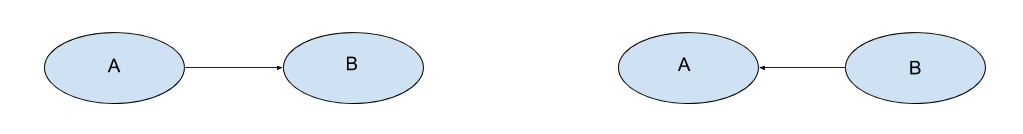

In [42]:
Image('../images/2/two_nodes.png')

In the above two cases it is fairly obvious that change in any of the node will affect the other. For the first case we can take the example of $difficulty \rightarrow grade$. If we increase the difficulty of the course the probability of getting a higher grade decreases. For the second case we can take the example of $SAT \leftarrow Intel$. Now if we increase the probability of getting a good score in SAT that would imply that the student is intelligent, hence increasing the probability of $i_1$. Therefore in both the cases shown above any change in the variables leads to change in the other variable.

Now, there are four possible ways of connection between 3 nodes: 

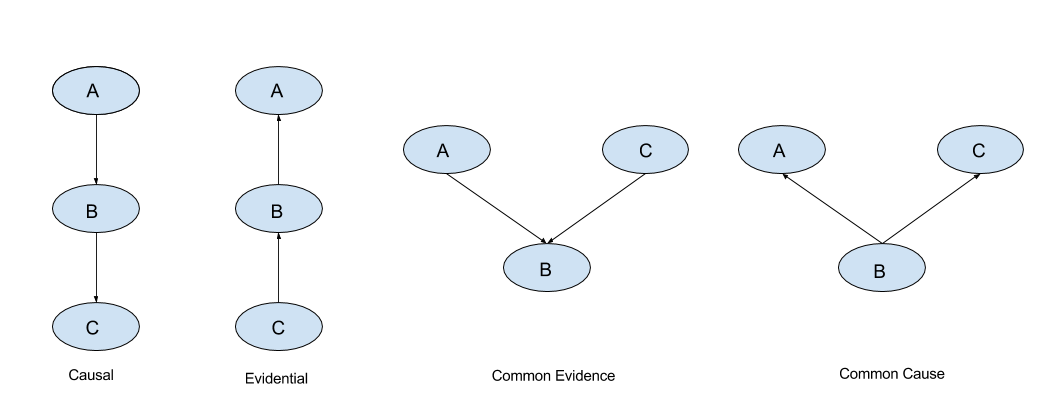

In [43]:
Image('../images/2/three_nodes.png')

Now in the above cases we will see the flow of influence from $A$ to $C$ under various cases.

1. __Causal:__ In the general case when we make any changes in the variable $A$, it will have effect of variable $B$ (as we discussed above) and this change in $B$ will change the values in $C$. One other possible case can be when $B$ is observed i.e. we know the value of $B$. So, in this case any change in $A$ won't affect $B$ since we already know the value. And hence there won't be any change in $C$ as it depends only on $B$. Mathematically  we can say that: $(A \perp C | B)$.
2. __Evidential:__ Similarly in this case also observing $B$ renders $C$ independent of $A$. Otherwise when $B$ is not observed the influence flows from $A$ to $C$. Hence $(A \perp C | B)$.
3. __Common Evidence:__ This case is a bit different from the others. When $B$ is not observed any change in $A$ reflects some change in $B$ but not in $C$. Let's take the example of $D \rightarrow G \leftarrow I$. In this case if we increase the difficulty of the course the probability of getting a higher grade reduces but this has no effect on the intelligence of the student. But when $B$ is observed let's say that the student got a good grade. Now if we increase the difficulty of the course this will increase the probability of the student to be intelligent since we already know that he got a good grade. Hence in this case $(A \perp C)$ and $( A \not\perp C | B)$. This structure is also commonly known as V structure.
4. __Common Cause:__ The influence flows from $A$ to $C$ when $B$ is not observed. But when $B$ is observed and change in $A$ doesn't affect $C$ since it's only dependent on $B$. Hence here also $( A \perp C | B)$. 

Let's not see a few examples for finding the independencies in a newtork using pgmpy:

In [44]:
# Getting the local independencies of a variable.
model.local_independencies('G')

(G _|_ S | I, D)

In [45]:
# Getting all the local independencies in the network.
model.local_independencies(['D', 'I', 'S', 'G', 'L'])

(D _|_ I, S)
(I _|_ D)
(S _|_ G, L, D | I)
(G _|_ S | I, D)
(L _|_ I, D, S | G)

In [48]:
# Active trail: For any two variables A and B in a network if any change in A influences the values of B then we say
#               that there is an active trail between A and B.
# In pgmpy active_trail_nodes gives a set of nodes which are affected (i.e. correlated) by any 
# change in the node passed in the argument.
model.active_trail_nodes('D')

{'D': {'D', 'G', 'L'}}

In [49]:
model.active_trail_nodes('D', observed='G')

{'D': {'D', 'I', 'S'}}

### 3. How is this Bayesian Network representing the Joint Distribution over the variables ?
Till now we just have been considering that the Bayesian Network can represent the Joint Distribution without any proof. Now let's see how to compute the Joint Distribution from the Bayesian Network.

From the chain rule of probabiliy we know that:

$P(A, B) = P(A | B) * P(B)$

Now in this case:

$P(D, I, G, L, S) = P(L| S, G, D, I) * P(S | G, D, I) * P(G | D, I) * P(D | I) * P(I)$

Applying the local independence conditions in the above equation we will get:

$P(D, I, G, L, S) = P(L|G) * P(S|I) * P(G| D, I) * P(D) * P(I)$

From the above equation we can clearly see that the Joint Distribution over all the variables is just the product of all the CPDs in the network. Hence encoding the independencies in the Joint Distribution in a graph structure helped us in reducing the number of parameters that we need to store.

### 4. Inference in Bayesian Models
Till now we discussed just about representing Bayesian Networks. Now let's see how we can do inference in a Bayesian Model and use it to predict values over new data points for machine learning tasks. In this section we will consider that we already have our model. We will talk about constructing the models from data in later parts of this tutorial.

In inference we try to answer probability queries over the network given some other variables. So, we might want to know the probable grade of an intelligent student in a difficult class given that he scored good in SAT. So for computing these values from a Joint Distribution we will have to reduce over the given variables that is $I = 1$, $D = 1$, $S = 1$ and then marginalize over the other variables that is $L$ to get $P(G | I=1, D=1, S=1)$.
But carrying on marginalize and reduce operation on the complete Joint Distribution is computationaly expensive since we need to iterate over the whole table for each operation and the table is exponential is size to the number of variables. But in Graphical Models we exploit the independencies to break these operations in smaller parts making it much faster.

One of the very basic methods of inference in Graphical Models is __Variable Elimination__.

#### Variable Elimination
We know that:

$P(D, I, G, L, S) = P(L|G) * P(S|I) * P(G|D, I) * P(D) * P(I)$

Now let's say we just want to compute the probability of G. For that we will need to marginalize over all the other variables.

$P(G) = \sum_{D, I, L, S} P(D, I, G, L, S)$

$P(G) = \sum_{D, I, L, S} P(L|G) * P(S|I) * P(G|D, I) * P(D) * P(I)$

$P(G) = \sum_D \sum_I \sum_L \sum_S P(L|G) * P(S|I) * P(G|D, I) * P(D) * P(I)$

Now since not all the conditional distributions depend on all the variables we can push the summations inside:

$P(G) = \sum_D \sum_I \sum_L \sum_S P(L|G) * P(S|I) * P(G|D, I) * P(D) * P(I)$

$P(G) = \sum_D P(D) \sum_I P(G|D, I) * P(I) \sum_S P(S|I) \sum_L P(L|G)$

So, by pushing the summations inside we have saved a lot of computation because we have to now iterate over much smaller tables.

Let's take an example for inference using Variable Elimination in pgmpy:

In [52]:
from pgmpy.inference import VariableElimination
infer = VariableElimination(model)
g_dist = infer.query(['G'])
print(g_dist)

Eliminating: I: 100%|██████████| 4/4 [00:00<00:00, 240.56it/s]

+------+----------+
| G    |   phi(G) |
+======+==========+
| G(A) |   0.3620 |
+------+----------+
| G(B) |   0.2884 |
+------+----------+
| G(C) |   0.3496 |
+------+----------+


There can be cases in which we want to compute the conditional distribution let's say $P(G | D=0, I=1)$. In such cases we need to modify our equations a bit:

$P(G | D=0, I=1) = \sum_L \sum_S P(L|G) * P(S| I=1) * P(G| D=0, I=1) * P(D=0) * P(I=1)$

$P(G | D=0, I=1) = P(D=0) * P(I=1) * P(G | D=0, I=1) * \sum_L P(L | G) * \sum_S P(S | I=1)$

In pgmpy we will just need to pass an extra argument in the case of conditional distributions:

In [58]:
print(infer.query(['G'], evidence={'D': 'Easy', 'I': 'Intelligent'}))

Eliminating: S: 100%|██████████| 2/2 [00:00<00:00, 326.68it/s]

+------+----------+
| G    |   phi(G) |
+======+==========+
| G(A) |   0.9000 |
+------+----------+
| G(B) |   0.0800 |
+------+----------+
| G(C) |   0.0200 |
+------+----------+


####  Predicting values from new data points
Predicting values from new data points is quite similar to computing the conditional probabilities. We need to query for the variable that we need to predict given all the other features. The only difference is that rather than getting the probabilitiy distribution we are interested in getting the most probable state of the variable.

In pgmpy this is known as MAP query. Here's an example:

In [59]:
infer.map_query(['G'])

Eliminating: I: 100%|██████████| 4/4 [00:00<00:00, 273.20it/s]


{'G': 'A'}

In [60]:
infer.map_query(['G'], evidence={'D': 'Easy', 'I': 'Intelligent'})

Eliminating: S: 100%|██████████| 2/2 [00:00<00:00, 219.08it/s]


{'G': 'A'}

In [61]:
infer.map_query(['G'], evidence={'D': 'Easy', 'I': 'Intelligent', 'L': 'Good', 'S': 'Good'})

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


{'G': 'A'}

### 5. Other methods for Inference
Even though exact inference algorithms like Variable Elimination optimize the inference task, it is still computationally quite expensive in the case of large models. For such cases we can use approximate algorithms like Message Passing Algorithms, Sampling Algorithms etc. We will talk about a few other exact and approximate algorithms in later parts of the tutorial.